<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/COMP5623M_CW1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


ml20baya

Your full name:

Buthaina Abdullah Alshareef

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [2]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

# Imports
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms,utils
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

Tesla P100-PCIE-16GB
1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT_DIR = "/content/drive/MyDrive/comp5623m-2022/train_set/train_set/"
ROOT = "/content/drive/MyDrive/comp5623m-2022/"
mapping_img30 = "/content/drive/MyDrive/comp5623m-2022/mapping.txt"


In [ ]:
#!unzip "/content/drive/MyDrive/comp5623m-2022_z.zip" -d "/content"

In [6]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CLASS_LABELS = ["baboon",
                "banana"
                ,"bee"
                ,"bison"
                ,"butterfly"
                ,"candle"
                ,"cardigan"
                ,"chihuahua"
                ,"elephant"
                ,"espresso"
                ,"fly"
                ,"goldfish"
                ,"goose"
                ,"grasshopper"
                ,"hourglass"
                ,"icecream"
                ,"ipod"
                ,"jellyfish"
                ,"koala"
                ,"ladybug"
                ,"lion"
                ,"mushroom"
                ,"penguin"
                ,"pig"
                ,"pizza"
                ,"pretzel"
                ,"redpanda"
                ,"refrigerator"
                ,"sombrero"
                ,"umbrella"]



mean =  [0.4828, 0.4419, 0.3691]
std = [0.2130, 0.2060, 0.2022]

class TinyImageNet30(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_x = Image.open(self.df['path'][index])
        
        try:
            img_x = img_x.convert('RGB')
            
        except:
            pass
        
        img_y = torch.tensor(int(self.df['class'][index]))
        
        if self.transform:
            img_x = self.transform(img_x)
        return img_x,img_y
        

paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            paths.append(entry.path)
            classes.append(i)
            
data = {'path': paths,'class': classes}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True)


print("Found", len(data_df), "images.")
print(data_df.head())

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Split the data into train and test sets
train_split = 0.80 
train_size = int(len(data_df)*train_split)


train_dataset = TinyImageNet30(
    df=data_df[:train_size],
    transform=trnsfrm,
)

valid_dataset = TinyImageNet30(
    df=data_df[train_size:].reset_index(drop=True),
    transform=trnsfrm,
)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True,num_workers=6)

valid_loader = DataLoader(valid_dataset, batch_size=64,shuffle=True,num_workers=6)


print("dataset_train length", len(train_dataset))
print("dataset_valid length", len(valid_dataset))
print("train_loader length", len(train_loader))
print("valid_loader length", len(valid_loader))



Found 13500 images.
                                                path  class
0  /content/drive/MyDrive/comp5623m-2022/train_se...     20
1  /content/drive/MyDrive/comp5623m-2022/train_se...      1
2  /content/drive/MyDrive/comp5623m-2022/train_se...     16
3  /content/drive/MyDrive/comp5623m-2022/train_se...     15
4  /content/drive/MyDrive/comp5623m-2022/train_se...      9
dataset_train length 10800
dataset_valid length 2700
train_loader length 169
valid_loader length 43


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


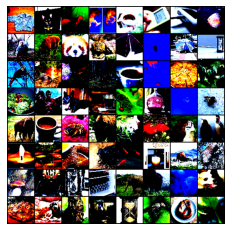

6 7 11 17 9 16 16 11 0 3 26 20 29 17 29 14 26 11 4 3 9 17 24 22 15 7 7 9 19 14 17 2 3 9 2 3 26 11 20 22 5 11 25 10 11 9 3 18 11 10 14 27 8 3 17 7 24 7 21 20 14 10 25 10


In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa
    
# single batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.size())

#disply images
timshow(utils.make_grid(images))
print(*labels.numpy())     # * unpack the ndarray

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [ ]:
class model112(nn.Module):
  def __init__(self):
    super(model112, self).__init__()

    self.conv1 = nn.Conv2d(3, 87, kernel_size= 5, padding= 0)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(87, 64, kernel_size= 3, padding= 0)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    self.fcl1 = nn.Linear(14*14*64, 1500)

    self.fcl2 = nn.Linear(1500, 30)
        
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.mp1(x)

    x = F.relu(self.conv2(x))
    x = self.mp2(x)

    x = x.reshape(-1, 14*14*64)

    x = self.fcl1(x)
    x = F.relu(x)

    x = self.fcl2(x)
    return x
model122 = model112()
model112 = nn.DataParallel(model122)
model112 = model112.to(device)
summary(model112.to(device), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 87, 60, 60]           6,612
         MaxPool2d-2           [-1, 87, 30, 30]               0
            Conv2d-3           [-1, 64, 28, 28]          50,176
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Linear-5                 [-1, 1500]      18,817,500
            Linear-6                   [-1, 30]          45,030
          model112-7                   [-1, 30]               0
Total params: 18,919,318
Trainable params: 18,919,318
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.48
Params size (MB): 72.17
Estimated Total Size (MB): 75.70
----------------------------------------------------------------


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [7]:
#validation for all models
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    # net = net.to(device)
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [ ]:
#Run single batch
nepochs = 50
results_path = ROOT+'results/singlebatch50epochsClass.pt'

statsrec = np.zeros((4,nepochs))

data = next(iter(train_loader))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model112.parameters(), lr=0.01, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    
    # get a batch of random training examples (images and corresponding labels)
    
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
        
         # Zero the parameter gradients
    optimizer.zero_grad()

        # Forward, backward, and update parameters
    outputs = model112(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    
        # accumulate loss
    running_loss += loss.item()
    n += 1
        
        # accumulate data for accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)    # add in the number of labels in this minibatch
    correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(valid_loader, model112)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst: .3f} validation accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": model112.state_dict(), "stats": statsrec}, results_path)

# save network parameters and losses
#torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 training loss:  2.184 training accuracy:  34.4%  validation loss:  2.214 validation accuracy:  35.6%
epoch: 1 training loss:  1.983 training accuracy:  39.1%  validation loss:  2.227 validation accuracy:  36.0%
epoch: 2 training loss:  1.714 training accuracy:  59.4%  validation loss:  2.272 validation accuracy:  34.4%
epoch: 3 training loss:  1.469 training accuracy:  60.9%  validation loss:  2.360 validation accuracy:  31.7%
epoch: 4 training loss:  1.234 training accuracy:  67.2%  validation loss:  2.479 validation accuracy:  30.5%
epoch: 5 training loss:  0.992 training accuracy:  75.0%  validation loss:  2.647 validation accuracy:  29.1%
epoch: 6 training loss:  0.771 training accuracy:  79.7%  validation loss:  2.851 validation accuracy:  27.7%
epoch: 7 training loss:  0.583 training accuracy:  87.5%  validation loss:  3.047 validation accuracy:  26.8%
epoch: 8 training loss:  0.429 training accuracy:  95.3%  validation loss:  3.262 validation accuracy:  25.9%
epoch: 9 t

In [8]:
#define function for all models visulization
def viz_model(resultPath):  
  results_path = ROOT+ resultPath
  data = torch.load(results_path)


  statsrec = data["stats"]
  fig, ax1 = plt.subplots()
  plt.plot(statsrec[0], 'r', label = 'training loss', )
  plt.plot(statsrec[2], 'g', label = 'validation loss' )
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training and validation loss, and validation accuracy')
  ax2=ax1.twinx()
  ax2.plot(statsrec[1], 'm', label = 'training accuracy')
  ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
  ax2.set_ylabel('accuracy')
  plt.legend(loc='upper right')
  fig.savefig("roc.svg")
  plt.show()

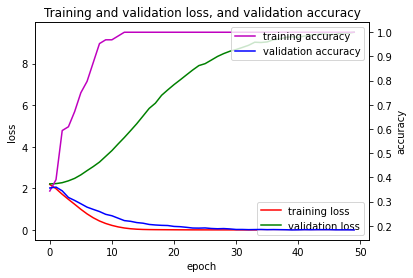

In [ ]:
viz_model('results/singlebatch50epochsClass.pt')



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [ ]:
# instantiate your new Model class
# Function for complete dataset training 
def run_model(epoch, resultPath, learningRate, train_loader, model, loss):
  loss_fn = nn.CrossEntropyLoss()
  nepochs = epoch
  results_path = ROOT+ resultPath
  statsrec = np.zeros((4,nepochs))
  

  optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)
  #optimizer = optim.Adam(model_122a.parameters(), lr=learningRate, momentum=0.9)


  for epoch in range(nepochs):  # loop over the dataset multiple times
      correct = 0          # number of examples predicted correctly (for accuracy)
      total = 0            # number of examples
      running_loss = 0.0   # accumulated loss (for mean loss)
      n = 0                # number of minibatches
      for data in tqdm(train_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward, backward, and update parameters
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
      
          # accumulate loss
          running_loss += loss.item()
          n += 1
          
          # accumulate data for accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)    # add in the number of labels in this minibatch
          correct += (predicted == labels).sum().item()  # add in the number of correct labels
      
      # collect together statistics for this epoch
      ltrn = running_loss/n
      atrn = correct/total 
      ltst, atst = stats(valid_loader, model)
      statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
      print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst.cpu(): .3f} validation accuracy: {atst: .1%}")

      # save network parameters, losses and accuracy
  torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)

In [ ]:
run_model(50, 'results/completedataset50epochsClass.pt', 0.01, train_loader, model112)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:23<00:00,  7.26it/s]


epoch: 0 training loss:  2.422 training accuracy:  33.2%  validation loss:  2.234 validation accuracy:  37.2%


100%|██████████| 169/169 [00:19<00:00,  8.61it/s]


epoch: 1 training loss:  1.769 training accuracy:  48.8%  validation loss:  2.304 validation accuracy:  37.3%


100%|██████████| 169/169 [00:21<00:00,  8.02it/s]


epoch: 2 training loss:  1.230 training accuracy:  63.5%  validation loss:  2.336 validation accuracy:  38.6%


100%|██████████| 169/169 [00:27<00:00,  6.12it/s]


epoch: 3 training loss:  0.681 training accuracy:  79.4%  validation loss:  2.698 validation accuracy:  37.8%


100%|██████████| 169/169 [00:25<00:00,  6.52it/s]


epoch: 4 training loss:  0.311 training accuracy:  90.9%  validation loss:  3.003 validation accuracy:  38.3%


100%|██████████| 169/169 [00:27<00:00,  6.21it/s]


epoch: 5 training loss:  0.129 training accuracy:  96.2%  validation loss:  3.777 validation accuracy:  37.8%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 6 training loss:  0.080 training accuracy:  97.7%  validation loss:  4.108 validation accuracy:  38.9%


100%|██████████| 169/169 [00:24<00:00,  6.98it/s]


epoch: 7 training loss:  0.048 training accuracy:  98.7%  validation loss:  3.881 validation accuracy:  39.3%


100%|██████████| 169/169 [00:22<00:00,  7.58it/s]


epoch: 8 training loss:  0.046 training accuracy:  98.9%  validation loss:  4.224 validation accuracy:  39.7%


100%|██████████| 169/169 [00:29<00:00,  5.65it/s]


epoch: 9 training loss:  0.022 training accuracy:  99.4%  validation loss:  4.334 validation accuracy:  39.1%


100%|██████████| 169/169 [00:24<00:00,  6.95it/s]


epoch: 10 training loss:  0.022 training accuracy:  99.6%  validation loss:  4.216 validation accuracy:  39.7%


100%|██████████| 169/169 [00:23<00:00,  7.35it/s]


epoch: 11 training loss:  0.008 training accuracy:  99.8%  validation loss:  4.405 validation accuracy:  41.2%


100%|██████████| 169/169 [00:21<00:00,  7.84it/s]


epoch: 12 training loss:  0.002 training accuracy:  100.0%  validation loss:  4.483 validation accuracy:  41.4%


100%|██████████| 169/169 [00:23<00:00,  7.26it/s]


epoch: 13 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.517 validation accuracy:  41.0%


100%|██████████| 169/169 [00:24<00:00,  6.79it/s]


epoch: 14 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.576 validation accuracy:  41.1%


100%|██████████| 169/169 [00:22<00:00,  7.40it/s]


epoch: 15 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.672 validation accuracy:  41.3%


100%|██████████| 169/169 [00:20<00:00,  8.09it/s]


epoch: 16 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.752 validation accuracy:  41.3%


100%|██████████| 169/169 [00:20<00:00,  8.05it/s]


epoch: 17 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.775 validation accuracy:  41.3%


100%|██████████| 169/169 [00:21<00:00,  8.05it/s]


epoch: 18 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.783 validation accuracy:  41.4%


100%|██████████| 169/169 [00:21<00:00,  7.94it/s]


epoch: 19 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.788 validation accuracy:  41.5%


100%|██████████| 169/169 [00:24<00:00,  6.80it/s]


epoch: 20 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.860 validation accuracy:  41.6%


100%|██████████| 169/169 [00:21<00:00,  8.01it/s]


epoch: 21 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.908 validation accuracy:  41.6%


100%|██████████| 169/169 [00:21<00:00,  7.90it/s]


epoch: 22 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.914 validation accuracy:  41.6%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 23 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.925 validation accuracy:  41.6%


100%|██████████| 169/169 [00:24<00:00,  6.99it/s]


epoch: 24 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.020 validation accuracy:  41.6%


100%|██████████| 169/169 [00:24<00:00,  6.98it/s]


epoch: 25 training loss:  0.000 training accuracy:  100.0%  validation loss:  4.980 validation accuracy:  41.6%


100%|██████████| 169/169 [00:21<00:00,  7.99it/s]


epoch: 26 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.003 validation accuracy:  41.6%


100%|██████████| 169/169 [00:21<00:00,  7.91it/s]


epoch: 27 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.063 validation accuracy:  41.6%


100%|██████████| 169/169 [00:26<00:00,  6.26it/s]


epoch: 28 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.096 validation accuracy:  41.6%


100%|██████████| 169/169 [00:21<00:00,  7.99it/s]


epoch: 29 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.059 validation accuracy:  41.7%


100%|██████████| 169/169 [00:28<00:00,  5.89it/s]


epoch: 30 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.194 validation accuracy:  41.8%


100%|██████████| 169/169 [00:27<00:00,  6.17it/s]


epoch: 31 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.201 validation accuracy:  41.8%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 32 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.159 validation accuracy:  41.9%


100%|██████████| 169/169 [00:21<00:00,  7.93it/s]


epoch: 33 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.182 validation accuracy:  41.9%


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


epoch: 34 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.192 validation accuracy:  41.9%


100%|██████████| 169/169 [00:21<00:00,  7.79it/s]


epoch: 35 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.173 validation accuracy:  42.0%


100%|██████████| 169/169 [00:24<00:00,  6.94it/s]


epoch: 36 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.254 validation accuracy:  42.0%


100%|██████████| 169/169 [00:22<00:00,  7.49it/s]


epoch: 37 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.203 validation accuracy:  42.0%


100%|██████████| 169/169 [00:21<00:00,  7.95it/s]


epoch: 38 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.257 validation accuracy:  42.1%


100%|██████████| 169/169 [00:29<00:00,  5.77it/s]


epoch: 39 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.239 validation accuracy:  42.1%


100%|██████████| 169/169 [00:25<00:00,  6.51it/s]


epoch: 40 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.283 validation accuracy:  42.1%


100%|██████████| 169/169 [00:25<00:00,  6.52it/s]


epoch: 41 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.316 validation accuracy:  42.1%


100%|██████████| 169/169 [00:24<00:00,  6.99it/s]


epoch: 42 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.333 validation accuracy:  42.1%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 43 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.305 validation accuracy:  42.1%


100%|██████████| 169/169 [00:23<00:00,  7.24it/s]


epoch: 44 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.314 validation accuracy:  42.1%


100%|██████████| 169/169 [00:24<00:00,  6.77it/s]


epoch: 45 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.363 validation accuracy:  42.1%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 46 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.376 validation accuracy:  42.1%


100%|██████████| 169/169 [00:25<00:00,  6.51it/s]


epoch: 47 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.363 validation accuracy:  42.0%


100%|██████████| 169/169 [00:22<00:00,  7.53it/s]


epoch: 48 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.396 validation accuracy:  42.1%


100%|██████████| 169/169 [00:22<00:00,  7.65it/s]


epoch: 49 training loss:  0.000 training accuracy:  100.0%  validation loss:  5.342 validation accuracy:  42.1%


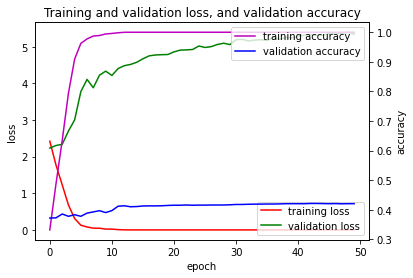

In [ ]:
viz_model('results/completedataset50epochsClass.pt')


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [9]:
#method 1
trnsfrm_augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean, std)
])

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [10]:
train_dataset_fine = TinyImageNet30(
    df=data_df[:train_size],
    transform=trnsfrm_augmentation,
)

valid_dataset = TinyImageNet30(
    df=data_df[train_size:].reset_index(drop=True),
    transform=trnsfrm,
)

train_loader = DataLoader(train_dataset_fine, batch_size=64,shuffle=True,num_workers=6)

valid_loader = DataLoader(valid_dataset, batch_size=128,shuffle=True,num_workers=6)


print("len(dataset_train)", len(train_dataset))
print("len(dataset_valid)", len(valid_dataset))

print("len(train_loader)", len(train_loader))
print("len(valid_loader)", len(valid_loader))

len(dataset_train) 10800
len(dataset_valid) 2700
len(train_loader) 169
len(valid_loader) 22


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
#yes 53% test 51%
model_122a = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(320*8*8, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122a.to(device), input_size=(3, 64, 64))
model_122a = model_122a.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
          Flatten-13                [-1, 20480]               0
           Linear-14                 [-

In [ ]:
#the best  ? gave test 54%
class model_122b(nn.Module):
  def __init__(self):
    super(model_122b, self).__init__()

    self.conv1 = nn.Conv2d(3, 128, kernel_size= 3, padding= 1)
    self.bn1 = nn.BatchNorm2d(128)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(128, 260, kernel_size= 3, padding= 1)
    self.bn2 = nn.BatchNorm2d(260)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(260, 320, kernel_size= 3, padding= 1)
    self.bn3 = nn.BatchNorm2d(320)
    self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    self.fcl1 = nn.Linear(320*8*8, 1500)
    self.dpo1 = nn.Dropout(0.5)

    self.fcl2 = nn.Linear(1500, 700)
    self.dpo2 = nn.Dropout(0.2)

    self.fcl3 = nn.Linear(700, 30)
        
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)
    x = self.mp1(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    x = self.mp2(x)

    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.mp3(x)

    x = x.reshape(-1, 320*8*8)

    x = self.fcl1(x)
    x = self.dpo1(x)
    x = F.relu(x)

    x = self.fcl2(x)
    x = self.dpo2(x)
    x = F.relu(x)

    x = self.fcl3(x)
    return x
model_122b = model_122b()
model_122b = nn.DataParallel(model_122b)
model_122b = model_122b.to(device) 
summary(model_122b.to(device), input_size=(3, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
         MaxPool2d-3          [-1, 128, 32, 32]               0
            Conv2d-4          [-1, 260, 32, 32]         299,780
       BatchNorm2d-5          [-1, 260, 32, 32]             520
         MaxPool2d-6          [-1, 260, 16, 16]               0
            Conv2d-7          [-1, 320, 16, 16]         749,120
       BatchNorm2d-8          [-1, 320, 16, 16]             640
         MaxPool2d-9            [-1, 320, 8, 8]               0
           Linear-10                 [-1, 1500]      30,721,500
          Dropout-11                 [-1, 1500]               0
           Linear-12                  [-1, 700]       1,050,700
          Dropout-13                  [-1, 700]               0
           Linear-14                   

In [54]:
# 59% validation but overfiting
class model_122c(nn.Module):
  def __init__(self):
    super(model_122c, self).__init__()

    self.conv1 = nn.Conv2d(3, 128, kernel_size= 3, padding= 1)
    self.bn1 = nn.BatchNorm2d(128)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(128, 260, kernel_size= 3, padding= 1)
    self.bn2 = nn.BatchNorm2d(260)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(260, 320, kernel_size= 3, padding= 1)
    self.bn3 = nn.BatchNorm2d(320)
    self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(320, 460, kernel_size= 3, padding= 1)
    self.bn4 = nn.BatchNorm2d(460)
    self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)

        
    self.fcl1 = nn.Linear(460*4*4, 1500)
    self.dpo1 = nn.Dropout(0.5)

    self.fcl2 = nn.Linear(1500, 700)
    self.dpo2 = nn.Dropout(0.2)

    self.fcl3 = nn.Linear(700, 30)
        
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)
    x = self.mp1(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    x = self.mp2(x)

    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.mp3(x)

    x = F.relu(self.conv4(x))
    x = self.bn4(x)
    x = self.mp4(x)

    x = x.reshape(-1, 460*4*4)

    x = self.fcl1(x)
    x = self.dpo1(x)
    x = F.relu(x)

    x = self.fcl2(x)
    x = self.dpo2(x)
    x = F.relu(x)

    x = self.fcl3(x)
    return x
model_122c = model_122c()
model_122c = nn.DataParallel(model_122c)
model_122c = model_122c.to(device) 
summary(model_122c.to(device), input_size=(3, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
         MaxPool2d-3          [-1, 128, 32, 32]               0
            Conv2d-4          [-1, 260, 32, 32]         299,780
       BatchNorm2d-5          [-1, 260, 32, 32]             520
         MaxPool2d-6          [-1, 260, 16, 16]               0
            Conv2d-7          [-1, 320, 16, 16]         749,120
       BatchNorm2d-8          [-1, 320, 16, 16]             640
         MaxPool2d-9            [-1, 320, 8, 8]               0
           Conv2d-10            [-1, 460, 8, 8]       1,325,260
      BatchNorm2d-11            [-1, 460, 8, 8]             920
        MaxPool2d-12            [-1, 460, 4, 4]               0
           Linear-13                 [-1, 1500]      11,041,500
          Dropout-14                 [-

In [11]:
# 53% with test 50%

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122d = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(320*8*8, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122d.to(device), input_size=(3, 64, 64))
model_122d = model_122d.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
          Flatten-13                [-1, 20480]               0
           Linear-14                 [-

In [30]:
#validation 58% but test 0.56399 (the best)

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122e = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122e.to(device), input_size=(3, 64, 64))
model_122e = model_122e.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [40]:
# validation 57% test 0.55933

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122f = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122f.to(device), input_size=(3, 64, 64))
model_122f = model_122f.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [49]:
# 

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122g = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122g.to(device), input_size=(3, 64, 64))
model_122g = model_122g.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [98]:
#validation 58% but test 0.56399 (the best) tryi it with 100 now

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122h = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122h.to(device), input_size=(3, 64, 64))
model_122h = model_122h.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [12]:
def run_model(epoch, resultPath, learningRate, train_loader, model):

  nepochs = epoch
  #results_path = ROOT
  results_path = ROOT+ resultPath
  statsrec = np.zeros((4,nepochs))

  #loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)

  for epoch in range(nepochs):  # loop over the dataset multiple times
      correct = 0          # number of examples predicted correctly (for accuracy)
      total = 0            # number of examples
      running_loss = 0.0   # accumulated loss (for mean loss)
      n = 0                # number of minibatches
      for data in tqdm(train_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward, backward, and update parameters
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
      
          # accumulate loss
          running_loss += loss.item()
          n += 1
          
          # accumulate data for accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)    # add in the number of labels in this minibatch
          correct += (predicted == labels).sum().item()  # add in the number of correct labels
      
      # collect together statistics for this epoch
      ltrn = running_loss/n
      atrn = correct/total 
      ltst, atst = stats(valid_loader, model)
      statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
      print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst.cpu(): .3f} validation accuracy: {atst: .1%}")

      # save network parameters, losses and accuracy
  torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)


In [55]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
run_model(50,'results/FinecompletedatasetmodelA.pt',0.009, train_loader, model_122a)

In [ ]:
run_model(50,'results/FinecompletedatasetmodelB.pt',0.009, train_loader, model_122b)

In [56]:
run_model(50,'results/FinecompletedatasetmodelC.pt',0.009, train_loader, model_122c)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 0 training loss:  2.983 training accuracy:  15.3%  validation loss:  2.627 validation accuracy:  24.8%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 1 training loss:  2.608 training accuracy:  24.7%  validation loss:  2.350 validation accuracy:  31.8%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 2 training loss:  2.441 training accuracy:  29.6%  validation loss:  2.246 validation accuracy:  35.6%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 3 training loss:  2.277 training accuracy:  33.9%  validation loss:  2.141 validation accuracy:  36.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 4 training loss:  2.113 training accuracy:  38.3%  validation loss:  2.093 validation accuracy:  40.2%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 5 training loss:  2.030 training accuracy:  40.7%  validation loss:  1.985 validation accuracy:  43.5%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 6 training loss:  1.934 training accuracy:  42.6%  validation loss:  1.852 validation accuracy:  46.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 7 training loss:  1.820 training accuracy:  46.2%  validation loss:  1.851 validation accuracy:  47.3%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 8 training loss:  1.748 training accuracy:  48.6%  validation loss:  1.761 validation accuracy:  48.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 9 training loss:  1.660 training accuracy:  50.8%  validation loss:  1.742 validation accuracy:  50.5%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 10 training loss:  1.580 training accuracy:  53.3%  validation loss:  1.662 validation accuracy:  52.3%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 11 training loss:  1.518 training accuracy:  54.6%  validation loss:  1.720 validation accuracy:  51.3%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 12 training loss:  1.460 training accuracy:  56.3%  validation loss:  1.655 validation accuracy:  53.9%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 13 training loss:  1.380 training accuracy:  58.7%  validation loss:  1.661 validation accuracy:  52.4%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 14 training loss:  1.331 training accuracy:  60.2%  validation loss:  1.693 validation accuracy:  54.1%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 15 training loss:  1.303 training accuracy:  61.0%  validation loss:  1.657 validation accuracy:  54.7%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 16 training loss:  1.224 training accuracy:  63.1%  validation loss:  1.654 validation accuracy:  54.6%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 17 training loss:  1.184 training accuracy:  64.3%  validation loss:  1.692 validation accuracy:  54.9%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 18 training loss:  1.141 training accuracy:  66.0%  validation loss:  1.684 validation accuracy:  54.0%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 19 training loss:  1.101 training accuracy:  66.9%  validation loss:  1.627 validation accuracy:  56.4%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 20 training loss:  1.041 training accuracy:  68.1%  validation loss:  1.672 validation accuracy:  55.4%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 21 training loss:  1.008 training accuracy:  68.9%  validation loss:  1.625 validation accuracy:  56.7%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 22 training loss:  0.962 training accuracy:  70.7%  validation loss:  1.720 validation accuracy:  55.2%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 23 training loss:  0.913 training accuracy:  72.4%  validation loss:  1.716 validation accuracy:  56.8%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 24 training loss:  0.899 training accuracy:  72.9%  validation loss:  1.726 validation accuracy:  56.4%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 25 training loss:  0.856 training accuracy:  73.7%  validation loss:  1.705 validation accuracy:  57.3%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 26 training loss:  0.818 training accuracy:  74.9%  validation loss:  1.713 validation accuracy:  57.1%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 27 training loss:  0.787 training accuracy:  75.6%  validation loss:  1.785 validation accuracy:  57.6%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 28 training loss:  0.776 training accuracy:  76.1%  validation loss:  1.755 validation accuracy:  57.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 29 training loss:  0.760 training accuracy:  76.6%  validation loss:  1.662 validation accuracy:  57.6%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 30 training loss:  0.705 training accuracy:  78.2%  validation loss:  1.728 validation accuracy:  57.7%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 31 training loss:  0.666 training accuracy:  79.0%  validation loss:  1.790 validation accuracy:  57.8%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 32 training loss:  0.657 training accuracy:  80.1%  validation loss:  1.838 validation accuracy:  58.6%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 33 training loss:  0.617 training accuracy:  80.6%  validation loss:  1.950 validation accuracy:  57.7%


100%|██████████| 169/169 [00:30<00:00,  5.45it/s]


epoch: 34 training loss:  0.603 training accuracy:  81.1%  validation loss:  1.877 validation accuracy:  58.3%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 35 training loss:  0.579 training accuracy:  81.6%  validation loss:  1.829 validation accuracy:  58.5%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 36 training loss:  0.574 training accuracy:  82.2%  validation loss:  1.889 validation accuracy:  57.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 37 training loss:  0.548 training accuracy:  82.8%  validation loss:  1.917 validation accuracy:  56.8%


100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


epoch: 38 training loss:  0.514 training accuracy:  84.1%  validation loss:  1.986 validation accuracy:  57.3%


100%|██████████| 169/169 [00:31<00:00,  5.33it/s]


epoch: 39 training loss:  0.523 training accuracy:  83.7%  validation loss:  1.943 validation accuracy:  58.9%


100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


epoch: 40 training loss:  0.485 training accuracy:  85.0%  validation loss:  1.893 validation accuracy:  57.7%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 41 training loss:  0.479 training accuracy:  85.0%  validation loss:  1.971 validation accuracy:  57.7%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 42 training loss:  0.487 training accuracy:  84.7%  validation loss:  1.997 validation accuracy:  58.3%


100%|██████████| 169/169 [00:31<00:00,  5.40it/s]


epoch: 43 training loss:  0.451 training accuracy:  86.2%  validation loss:  1.955 validation accuracy:  57.9%


100%|██████████| 169/169 [00:32<00:00,  5.20it/s]


epoch: 44 training loss:  0.426 training accuracy:  86.7%  validation loss:  1.915 validation accuracy:  58.7%


100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


epoch: 45 training loss:  0.427 training accuracy:  86.6%  validation loss:  1.868 validation accuracy:  59.3%


100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


epoch: 46 training loss:  0.415 training accuracy:  87.0%  validation loss:  2.006 validation accuracy:  59.2%


100%|██████████| 169/169 [00:31<00:00,  5.36it/s]


epoch: 47 training loss:  0.418 training accuracy:  87.1%  validation loss:  2.106 validation accuracy:  58.1%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 48 training loss:  0.387 training accuracy:  87.8%  validation loss:  2.025 validation accuracy:  58.6%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 49 training loss:  0.384 training accuracy:  88.1%  validation loss:  2.045 validation accuracy:  58.2%


In [14]:
run_model(50,'results/FinecompletedatasetmodelD.pt',0.009, train_loader, model_122d)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [06:12<00:00,  2.20s/it]


epoch: 0 training loss:  3.147 training accuracy:  11.4%  validation loss:  2.840 validation accuracy:  17.1%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 1 training loss:  2.830 training accuracy:  19.0%  validation loss:  2.667 validation accuracy:  22.6%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 2 training loss:  2.726 training accuracy:  20.6%  validation loss:  2.663 validation accuracy:  24.8%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 3 training loss:  2.652 training accuracy:  23.5%  validation loss:  2.492 validation accuracy:  26.9%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 4 training loss:  2.586 training accuracy:  25.1%  validation loss:  2.498 validation accuracy:  26.9%


100%|██████████| 169/169 [00:30<00:00,  5.63it/s]


epoch: 5 training loss:  2.522 training accuracy:  26.7%  validation loss:  2.409 validation accuracy:  30.2%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 6 training loss:  2.487 training accuracy:  28.4%  validation loss:  2.363 validation accuracy:  33.1%


100%|██████████| 169/169 [00:29<00:00,  5.77it/s]


epoch: 7 training loss:  2.426 training accuracy:  29.2%  validation loss:  2.347 validation accuracy:  32.2%


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


epoch: 8 training loss:  2.381 training accuracy:  31.3%  validation loss:  2.299 validation accuracy:  33.8%


100%|██████████| 169/169 [00:30<00:00,  5.54it/s]


epoch: 9 training loss:  2.352 training accuracy:  31.4%  validation loss:  2.245 validation accuracy:  35.3%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 10 training loss:  2.291 training accuracy:  33.5%  validation loss:  2.242 validation accuracy:  35.8%


100%|██████████| 169/169 [00:31<00:00,  5.30it/s]


epoch: 11 training loss:  2.270 training accuracy:  34.1%  validation loss:  2.252 validation accuracy:  36.3%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 12 training loss:  2.221 training accuracy:  35.1%  validation loss:  2.154 validation accuracy:  38.8%


100%|██████████| 169/169 [00:29<00:00,  5.81it/s]


epoch: 13 training loss:  2.173 training accuracy:  36.2%  validation loss:  2.130 validation accuracy:  38.6%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 14 training loss:  2.156 training accuracy:  37.3%  validation loss:  2.162 validation accuracy:  39.7%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 15 training loss:  2.104 training accuracy:  38.8%  validation loss:  2.074 validation accuracy:  39.8%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 16 training loss:  2.097 training accuracy:  38.7%  validation loss:  2.088 validation accuracy:  40.3%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 17 training loss:  2.039 training accuracy:  40.6%  validation loss:  2.029 validation accuracy:  43.2%


100%|██████████| 169/169 [00:29<00:00,  5.74it/s]


epoch: 18 training loss:  2.032 training accuracy:  40.5%  validation loss:  1.980 validation accuracy:  42.0%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 19 training loss:  1.988 training accuracy:  41.6%  validation loss:  1.996 validation accuracy:  43.3%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 20 training loss:  1.960 training accuracy:  42.8%  validation loss:  1.964 validation accuracy:  43.7%


100%|██████████| 169/169 [00:29<00:00,  5.67it/s]


epoch: 21 training loss:  1.943 training accuracy:  42.4%  validation loss:  2.008 validation accuracy:  44.0%


100%|██████████| 169/169 [00:29<00:00,  5.70it/s]


epoch: 22 training loss:  1.919 training accuracy:  43.4%  validation loss:  1.985 validation accuracy:  43.4%


100%|██████████| 169/169 [00:29<00:00,  5.65it/s]


epoch: 23 training loss:  1.891 training accuracy:  43.7%  validation loss:  1.985 validation accuracy:  45.0%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 24 training loss:  1.866 training accuracy:  45.0%  validation loss:  1.949 validation accuracy:  45.3%


100%|██████████| 169/169 [00:29<00:00,  5.70it/s]


epoch: 25 training loss:  1.815 training accuracy:  46.4%  validation loss:  1.905 validation accuracy:  46.6%


100%|██████████| 169/169 [00:29<00:00,  5.70it/s]


epoch: 26 training loss:  1.819 training accuracy:  46.2%  validation loss:  1.993 validation accuracy:  44.2%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 27 training loss:  1.795 training accuracy:  46.5%  validation loss:  1.871 validation accuracy:  45.7%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 28 training loss:  1.763 training accuracy:  47.5%  validation loss:  1.870 validation accuracy:  45.9%


100%|██████████| 169/169 [00:29<00:00,  5.63it/s]


epoch: 29 training loss:  1.755 training accuracy:  48.0%  validation loss:  1.889 validation accuracy:  47.0%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 30 training loss:  1.711 training accuracy:  49.1%  validation loss:  1.859 validation accuracy:  46.6%


100%|██████████| 169/169 [00:30<00:00,  5.62it/s]


epoch: 31 training loss:  1.711 training accuracy:  49.6%  validation loss:  1.835 validation accuracy:  48.4%


100%|██████████| 169/169 [00:29<00:00,  5.69it/s]


epoch: 32 training loss:  1.676 training accuracy:  50.0%  validation loss:  1.799 validation accuracy:  48.6%


100%|██████████| 169/169 [00:29<00:00,  5.67it/s]


epoch: 33 training loss:  1.655 training accuracy:  50.3%  validation loss:  1.868 validation accuracy:  47.0%


100%|██████████| 169/169 [00:29<00:00,  5.72it/s]


epoch: 34 training loss:  1.652 training accuracy:  50.7%  validation loss:  1.832 validation accuracy:  49.2%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 35 training loss:  1.609 training accuracy:  52.0%  validation loss:  1.802 validation accuracy:  48.2%


100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


epoch: 36 training loss:  1.580 training accuracy:  52.3%  validation loss:  1.794 validation accuracy:  49.2%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 37 training loss:  1.546 training accuracy:  53.1%  validation loss:  1.821 validation accuracy:  49.0%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 38 training loss:  1.559 training accuracy:  52.5%  validation loss:  1.785 validation accuracy:  48.7%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 39 training loss:  1.541 training accuracy:  53.1%  validation loss:  1.743 validation accuracy:  49.8%


100%|██████████| 169/169 [00:29<00:00,  5.67it/s]


epoch: 40 training loss:  1.501 training accuracy:  54.3%  validation loss:  1.808 validation accuracy:  50.7%


100%|██████████| 169/169 [00:29<00:00,  5.69it/s]


epoch: 41 training loss:  1.497 training accuracy:  54.5%  validation loss:  1.786 validation accuracy:  50.4%


100%|██████████| 169/169 [00:30<00:00,  5.59it/s]


epoch: 42 training loss:  1.445 training accuracy:  56.2%  validation loss:  1.766 validation accuracy:  50.6%


100%|██████████| 169/169 [00:29<00:00,  5.73it/s]


epoch: 43 training loss:  1.434 training accuracy:  56.6%  validation loss:  1.687 validation accuracy:  51.9%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 44 training loss:  1.426 training accuracy:  57.3%  validation loss:  1.727 validation accuracy:  51.4%


100%|██████████| 169/169 [00:29<00:00,  5.66it/s]


epoch: 45 training loss:  1.399 training accuracy:  57.2%  validation loss:  1.705 validation accuracy:  52.3%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 46 training loss:  1.374 training accuracy:  58.2%  validation loss:  1.821 validation accuracy:  49.1%


100%|██████████| 169/169 [00:29<00:00,  5.76it/s]


epoch: 47 training loss:  1.376 training accuracy:  58.1%  validation loss:  1.719 validation accuracy:  52.7%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 48 training loss:  1.351 training accuracy:  58.7%  validation loss:  1.749 validation accuracy:  51.9%


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


epoch: 49 training loss:  1.332 training accuracy:  59.2%  validation loss:  1.694 validation accuracy:  53.1%


In [32]:
run_model(50,'results/FinecompletedatasetmodelE.pt',0.009, train_loader, model_122e)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:32<00:00,  5.21it/s]


epoch: 0 training loss:  3.092 training accuracy:  12.5%  validation loss:  2.735 validation accuracy:  20.6%


100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


epoch: 1 training loss:  2.722 training accuracy:  21.0%  validation loss:  2.599 validation accuracy:  24.9%


100%|██████████| 169/169 [00:32<00:00,  5.17it/s]


epoch: 2 training loss:  2.599 training accuracy:  24.7%  validation loss:  2.483 validation accuracy:  27.4%


100%|██████████| 169/169 [00:32<00:00,  5.18it/s]


epoch: 3 training loss:  2.489 training accuracy:  26.9%  validation loss:  2.309 validation accuracy:  32.4%


100%|██████████| 169/169 [00:32<00:00,  5.15it/s]


epoch: 4 training loss:  2.402 training accuracy:  29.6%  validation loss:  2.297 validation accuracy:  33.7%


100%|██████████| 169/169 [00:33<00:00,  5.11it/s]


epoch: 5 training loss:  2.303 training accuracy:  33.0%  validation loss:  2.241 validation accuracy:  34.9%


100%|██████████| 169/169 [00:32<00:00,  5.21it/s]


epoch: 6 training loss:  2.257 training accuracy:  34.3%  validation loss:  2.119 validation accuracy:  38.7%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 7 training loss:  2.178 training accuracy:  36.8%  validation loss:  2.045 validation accuracy:  39.4%


100%|██████████| 169/169 [00:32<00:00,  5.28it/s]


epoch: 8 training loss:  2.098 training accuracy:  38.5%  validation loss:  2.043 validation accuracy:  40.3%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 9 training loss:  2.029 training accuracy:  39.7%  validation loss:  2.043 validation accuracy:  40.7%


100%|██████████| 169/169 [00:31<00:00,  5.28it/s]


epoch: 10 training loss:  1.988 training accuracy:  41.4%  validation loss:  1.963 validation accuracy:  42.2%


100%|██████████| 169/169 [00:32<00:00,  5.27it/s]


epoch: 11 training loss:  1.926 training accuracy:  42.9%  validation loss:  1.888 validation accuracy:  43.7%


100%|██████████| 169/169 [00:31<00:00,  5.37it/s]


epoch: 12 training loss:  1.871 training accuracy:  44.7%  validation loss:  1.855 validation accuracy:  45.6%


100%|██████████| 169/169 [00:31<00:00,  5.36it/s]


epoch: 13 training loss:  1.854 training accuracy:  45.0%  validation loss:  1.836 validation accuracy:  46.8%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 14 training loss:  1.802 training accuracy:  46.5%  validation loss:  1.876 validation accuracy:  46.3%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 15 training loss:  1.762 training accuracy:  47.5%  validation loss:  1.813 validation accuracy:  48.9%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 16 training loss:  1.718 training accuracy:  48.9%  validation loss:  1.801 validation accuracy:  46.9%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 17 training loss:  1.693 training accuracy:  49.8%  validation loss:  1.725 validation accuracy:  50.2%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 18 training loss:  1.653 training accuracy:  50.7%  validation loss:  1.759 validation accuracy:  49.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 19 training loss:  1.631 training accuracy:  50.7%  validation loss:  1.770 validation accuracy:  48.4%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 20 training loss:  1.592 training accuracy:  52.4%  validation loss:  1.706 validation accuracy:  49.5%


100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


epoch: 21 training loss:  1.569 training accuracy:  52.7%  validation loss:  1.762 validation accuracy:  50.9%


100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


epoch: 22 training loss:  1.552 training accuracy:  53.7%  validation loss:  1.630 validation accuracy:  52.2%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 23 training loss:  1.508 training accuracy:  54.5%  validation loss:  1.737 validation accuracy:  50.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 24 training loss:  1.487 training accuracy:  55.6%  validation loss:  1.666 validation accuracy:  53.0%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 25 training loss:  1.452 training accuracy:  55.8%  validation loss:  1.666 validation accuracy:  52.9%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 26 training loss:  1.428 training accuracy:  56.9%  validation loss:  1.718 validation accuracy:  52.4%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 27 training loss:  1.433 training accuracy:  57.0%  validation loss:  1.690 validation accuracy:  52.9%


100%|██████████| 169/169 [00:30<00:00,  5.45it/s]


epoch: 28 training loss:  1.389 training accuracy:  57.6%  validation loss:  1.696 validation accuracy:  53.5%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 29 training loss:  1.358 training accuracy:  58.7%  validation loss:  1.652 validation accuracy:  54.4%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 30 training loss:  1.348 training accuracy:  58.6%  validation loss:  1.594 validation accuracy:  53.6%


100%|██████████| 169/169 [00:35<00:00,  4.79it/s]


epoch: 31 training loss:  1.323 training accuracy:  59.5%  validation loss:  1.622 validation accuracy:  53.9%


100%|██████████| 169/169 [00:32<00:00,  5.15it/s]


epoch: 32 training loss:  1.304 training accuracy:  60.1%  validation loss:  1.649 validation accuracy:  54.8%


100%|██████████| 169/169 [00:34<00:00,  4.93it/s]


epoch: 33 training loss:  1.267 training accuracy:  61.1%  validation loss:  1.596 validation accuracy:  54.8%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 34 training loss:  1.261 training accuracy:  60.9%  validation loss:  1.588 validation accuracy:  55.2%


100%|██████████| 169/169 [00:32<00:00,  5.22it/s]


epoch: 35 training loss:  1.224 training accuracy:  61.9%  validation loss:  1.585 validation accuracy:  56.4%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 36 training loss:  1.210 training accuracy:  62.8%  validation loss:  1.656 validation accuracy:  55.1%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 37 training loss:  1.183 training accuracy:  63.5%  validation loss:  1.679 validation accuracy:  55.1%


100%|██████████| 169/169 [00:32<00:00,  5.25it/s]


epoch: 38 training loss:  1.159 training accuracy:  64.2%  validation loss:  1.589 validation accuracy:  56.1%


100%|██████████| 169/169 [00:37<00:00,  4.48it/s]


epoch: 39 training loss:  1.137 training accuracy:  64.7%  validation loss:  1.617 validation accuracy:  56.1%


100%|██████████| 169/169 [00:40<00:00,  4.20it/s]


epoch: 40 training loss:  1.121 training accuracy:  64.9%  validation loss:  1.597 validation accuracy:  56.8%


100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


epoch: 41 training loss:  1.112 training accuracy:  65.9%  validation loss:  1.677 validation accuracy:  56.3%


100%|██████████| 169/169 [00:40<00:00,  4.19it/s]


epoch: 42 training loss:  1.074 training accuracy:  66.5%  validation loss:  1.613 validation accuracy:  55.7%


100%|██████████| 169/169 [00:39<00:00,  4.23it/s]


epoch: 43 training loss:  1.072 training accuracy:  67.1%  validation loss:  1.621 validation accuracy:  57.0%


100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


epoch: 44 training loss:  1.062 training accuracy:  66.9%  validation loss:  1.616 validation accuracy:  57.0%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 45 training loss:  1.035 training accuracy:  67.9%  validation loss:  1.645 validation accuracy:  57.5%


100%|██████████| 169/169 [00:40<00:00,  4.22it/s]


epoch: 46 training loss:  0.999 training accuracy:  69.1%  validation loss:  1.637 validation accuracy:  57.4%


100%|██████████| 169/169 [00:39<00:00,  4.23it/s]


epoch: 47 training loss:  0.984 training accuracy:  69.4%  validation loss:  1.585 validation accuracy:  56.7%


100%|██████████| 169/169 [00:39<00:00,  4.24it/s]


epoch: 48 training loss:  0.974 training accuracy:  69.7%  validation loss:  1.620 validation accuracy:  57.9%


100%|██████████| 169/169 [00:39<00:00,  4.24it/s]


epoch: 49 training loss:  0.953 training accuracy:  69.8%  validation loss:  1.576 validation accuracy:  58.1%


In [42]:
run_model(50,'results/FinecompletedatasetmodelF.pt',0.009, train_loader, model_122f)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


epoch: 0 training loss:  3.196 training accuracy:  10.3%  validation loss:  2.882 validation accuracy:  16.7%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 1 training loss:  2.835 training accuracy:  18.1%  validation loss:  2.672 validation accuracy:  22.1%


100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


epoch: 2 training loss:  2.715 training accuracy:  21.5%  validation loss:  2.576 validation accuracy:  26.7%


100%|██████████| 169/169 [00:32<00:00,  5.22it/s]


epoch: 3 training loss:  2.613 training accuracy:  24.7%  validation loss:  2.448 validation accuracy:  28.7%


100%|██████████| 169/169 [00:31<00:00,  5.33it/s]


epoch: 4 training loss:  2.554 training accuracy:  25.6%  validation loss:  2.468 validation accuracy:  29.0%


100%|██████████| 169/169 [00:31<00:00,  5.33it/s]


epoch: 5 training loss:  2.483 training accuracy:  28.2%  validation loss:  2.357 validation accuracy:  31.7%


100%|██████████| 169/169 [00:32<00:00,  5.18it/s]


epoch: 6 training loss:  2.420 training accuracy:  29.9%  validation loss:  2.301 validation accuracy:  33.3%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 7 training loss:  2.363 training accuracy:  31.4%  validation loss:  2.215 validation accuracy:  34.0%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 8 training loss:  2.303 training accuracy:  34.0%  validation loss:  2.256 validation accuracy:  34.3%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 9 training loss:  2.258 training accuracy:  35.0%  validation loss:  2.152 validation accuracy:  36.9%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 10 training loss:  2.205 training accuracy:  36.3%  validation loss:  2.200 validation accuracy:  35.9%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 11 training loss:  2.144 training accuracy:  37.9%  validation loss:  2.052 validation accuracy:  42.2%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 12 training loss:  2.113 training accuracy:  38.5%  validation loss:  2.056 validation accuracy:  41.7%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 13 training loss:  2.061 training accuracy:  40.2%  validation loss:  2.070 validation accuracy:  40.7%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 14 training loss:  2.025 training accuracy:  41.0%  validation loss:  2.034 validation accuracy:  42.2%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 15 training loss:  1.960 training accuracy:  42.3%  validation loss:  2.027 validation accuracy:  42.4%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 16 training loss:  1.957 training accuracy:  42.4%  validation loss:  1.980 validation accuracy:  44.1%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 17 training loss:  1.927 training accuracy:  44.4%  validation loss:  1.936 validation accuracy:  43.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 18 training loss:  1.883 training accuracy:  45.3%  validation loss:  1.925 validation accuracy:  45.6%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 19 training loss:  1.842 training accuracy:  46.6%  validation loss:  1.856 validation accuracy:  45.9%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 20 training loss:  1.830 training accuracy:  46.2%  validation loss:  1.955 validation accuracy:  45.4%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 21 training loss:  1.809 training accuracy:  47.4%  validation loss:  1.864 validation accuracy:  47.7%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 22 training loss:  1.766 training accuracy:  48.4%  validation loss:  1.864 validation accuracy:  46.9%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 23 training loss:  1.741 training accuracy:  48.7%  validation loss:  1.861 validation accuracy:  47.9%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 24 training loss:  1.686 training accuracy:  50.2%  validation loss:  1.802 validation accuracy:  48.3%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 25 training loss:  1.685 training accuracy:  50.9%  validation loss:  1.802 validation accuracy:  48.3%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 26 training loss:  1.659 training accuracy:  51.3%  validation loss:  1.742 validation accuracy:  50.3%


100%|██████████| 169/169 [00:27<00:00,  6.08it/s]


epoch: 27 training loss:  1.638 training accuracy:  52.1%  validation loss:  1.845 validation accuracy:  48.8%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 28 training loss:  1.623 training accuracy:  52.3%  validation loss:  1.715 validation accuracy:  51.6%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 29 training loss:  1.597 training accuracy:  53.1%  validation loss:  1.748 validation accuracy:  51.8%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 30 training loss:  1.571 training accuracy:  53.6%  validation loss:  1.727 validation accuracy:  51.5%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 31 training loss:  1.550 training accuracy:  53.9%  validation loss:  1.702 validation accuracy:  52.2%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 32 training loss:  1.534 training accuracy:  54.5%  validation loss:  1.703 validation accuracy:  52.5%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 33 training loss:  1.506 training accuracy:  55.6%  validation loss:  1.687 validation accuracy:  53.6%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 34 training loss:  1.476 training accuracy:  56.5%  validation loss:  1.685 validation accuracy:  52.9%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 35 training loss:  1.465 training accuracy:  56.7%  validation loss:  1.686 validation accuracy:  52.6%


100%|██████████| 169/169 [00:27<00:00,  6.09it/s]


epoch: 36 training loss:  1.447 training accuracy:  57.0%  validation loss:  1.673 validation accuracy:  53.1%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 37 training loss:  1.426 training accuracy:  57.7%  validation loss:  1.658 validation accuracy:  55.0%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 38 training loss:  1.411 training accuracy:  57.8%  validation loss:  1.672 validation accuracy:  54.2%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 39 training loss:  1.377 training accuracy:  59.1%  validation loss:  1.626 validation accuracy:  54.1%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 40 training loss:  1.363 training accuracy:  59.5%  validation loss:  1.640 validation accuracy:  52.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 41 training loss:  1.347 training accuracy:  59.9%  validation loss:  1.657 validation accuracy:  54.6%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 42 training loss:  1.308 training accuracy:  60.4%  validation loss:  1.601 validation accuracy:  54.8%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 43 training loss:  1.272 training accuracy:  61.9%  validation loss:  1.639 validation accuracy:  55.3%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 44 training loss:  1.277 training accuracy:  61.6%  validation loss:  1.652 validation accuracy:  55.5%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 45 training loss:  1.262 training accuracy:  62.0%  validation loss:  1.691 validation accuracy:  53.9%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 46 training loss:  1.257 training accuracy:  62.5%  validation loss:  1.638 validation accuracy:  55.6%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 47 training loss:  1.210 training accuracy:  63.5%  validation loss:  1.653 validation accuracy:  56.2%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 48 training loss:  1.215 training accuracy:  63.7%  validation loss:  1.670 validation accuracy:  57.1%


100%|██████████| 169/169 [00:27<00:00,  6.08it/s]


epoch: 49 training loss:  1.193 training accuracy:  64.2%  validation loss:  1.576 validation accuracy:  57.0%


In [51]:
loss_fn = nn.CrossEntropyLoss()
run_model(50,'results/FinecompletedatasetmodelG.pt',0.009, train_loader, model_122g)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:31<00:00,  5.30it/s]


epoch: 0 training loss:  3.000 training accuracy:  15.2%  validation loss:  2.614 validation accuracy:  23.5%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 1 training loss:  2.613 training accuracy:  23.8%  validation loss:  2.412 validation accuracy:  29.9%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 2 training loss:  2.424 training accuracy:  28.9%  validation loss:  2.358 validation accuracy:  32.1%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 3 training loss:  2.297 training accuracy:  32.7%  validation loss:  2.143 validation accuracy:  37.2%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 4 training loss:  2.177 training accuracy:  36.3%  validation loss:  2.177 validation accuracy:  36.0%


100%|██████████| 169/169 [00:31<00:00,  5.34it/s]


epoch: 5 training loss:  2.080 training accuracy:  39.6%  validation loss:  1.998 validation accuracy:  42.1%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 6 training loss:  1.975 training accuracy:  41.8%  validation loss:  1.903 validation accuracy:  45.0%


100%|██████████| 169/169 [00:31<00:00,  5.36it/s]


epoch: 7 training loss:  1.903 training accuracy:  43.6%  validation loss:  1.855 validation accuracy:  46.0%


100%|██████████| 169/169 [00:31<00:00,  5.31it/s]


epoch: 8 training loss:  1.827 training accuracy:  45.9%  validation loss:  1.778 validation accuracy:  48.6%


100%|██████████| 169/169 [00:31<00:00,  5.37it/s]


epoch: 9 training loss:  1.780 training accuracy:  47.7%  validation loss:  1.791 validation accuracy:  49.4%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 10 training loss:  1.701 training accuracy:  49.1%  validation loss:  1.726 validation accuracy:  49.3%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 11 training loss:  1.645 training accuracy:  51.1%  validation loss:  1.677 validation accuracy:  51.1%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 12 training loss:  1.596 training accuracy:  52.2%  validation loss:  1.662 validation accuracy:  52.0%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 13 training loss:  1.561 training accuracy:  53.1%  validation loss:  1.664 validation accuracy:  52.6%


100%|██████████| 169/169 [00:31<00:00,  5.39it/s]


epoch: 14 training loss:  1.488 training accuracy:  54.9%  validation loss:  1.638 validation accuracy:  53.1%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 15 training loss:  1.448 training accuracy:  55.8%  validation loss:  1.599 validation accuracy:  53.2%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 16 training loss:  1.401 training accuracy:  57.4%  validation loss:  1.608 validation accuracy:  55.1%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 17 training loss:  1.368 training accuracy:  58.2%  validation loss:  1.624 validation accuracy:  53.4%


100%|██████████| 169/169 [00:31<00:00,  5.42it/s]


epoch: 18 training loss:  1.333 training accuracy:  59.0%  validation loss:  1.616 validation accuracy:  54.1%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 19 training loss:  1.293 training accuracy:  59.7%  validation loss:  1.587 validation accuracy:  54.9%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 20 training loss:  1.243 training accuracy:  62.3%  validation loss:  1.600 validation accuracy:  54.6%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 21 training loss:  1.229 training accuracy:  61.9%  validation loss:  1.539 validation accuracy:  55.6%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 22 training loss:  1.166 training accuracy:  64.0%  validation loss:  1.574 validation accuracy:  56.2%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 23 training loss:  1.134 training accuracy:  65.5%  validation loss:  1.607 validation accuracy:  56.2%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 24 training loss:  1.102 training accuracy:  65.6%  validation loss:  1.536 validation accuracy:  57.4%


100%|██████████| 169/169 [00:31<00:00,  5.43it/s]


epoch: 25 training loss:  1.075 training accuracy:  66.9%  validation loss:  1.546 validation accuracy:  56.4%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 26 training loss:  1.044 training accuracy:  67.3%  validation loss:  1.592 validation accuracy:  55.8%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 27 training loss:  1.029 training accuracy:  67.7%  validation loss:  1.513 validation accuracy:  57.4%


100%|██████████| 169/169 [00:30<00:00,  5.49it/s]


epoch: 28 training loss:  0.972 training accuracy:  69.3%  validation loss:  1.564 validation accuracy:  58.3%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 29 training loss:  0.943 training accuracy:  70.6%  validation loss:  1.572 validation accuracy:  57.0%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 30 training loss:  0.911 training accuracy:  71.5%  validation loss:  1.591 validation accuracy:  58.4%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 31 training loss:  0.873 training accuracy:  72.5%  validation loss:  1.620 validation accuracy:  57.6%


100%|██████████| 169/169 [00:31<00:00,  5.40it/s]


epoch: 32 training loss:  0.863 training accuracy:  72.7%  validation loss:  1.585 validation accuracy:  58.4%


100%|██████████| 169/169 [00:30<00:00,  5.48it/s]


epoch: 33 training loss:  0.813 training accuracy:  74.3%  validation loss:  1.674 validation accuracy:  56.7%


100%|██████████| 169/169 [00:30<00:00,  5.47it/s]


epoch: 34 training loss:  0.822 training accuracy:  73.7%  validation loss:  1.560 validation accuracy:  58.9%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 35 training loss:  0.765 training accuracy:  75.8%  validation loss:  1.639 validation accuracy:  58.7%


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


epoch: 36 training loss:  0.737 training accuracy:  76.2%  validation loss:  1.604 validation accuracy:  58.5%


100%|██████████| 169/169 [00:31<00:00,  5.44it/s]


epoch: 37 training loss:  0.733 training accuracy:  76.7%  validation loss:  1.680 validation accuracy:  58.4%


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


epoch: 38 training loss:  0.697 training accuracy:  77.6%  validation loss:  1.714 validation accuracy:  57.2%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 39 training loss:  0.679 training accuracy:  78.3%  validation loss:  1.685 validation accuracy:  58.7%


100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


epoch: 40 training loss:  0.650 training accuracy:  79.0%  validation loss:  1.728 validation accuracy:  57.1%


100%|██████████| 169/169 [00:30<00:00,  5.46it/s]


epoch: 41 training loss:  0.638 training accuracy:  79.6%  validation loss:  1.770 validation accuracy:  57.7%


100%|██████████| 169/169 [00:31<00:00,  5.45it/s]


epoch: 42 training loss:  0.611 training accuracy:  80.1%  validation loss:  1.855 validation accuracy:  58.3%


100%|██████████| 169/169 [00:31<00:00,  5.40it/s]


epoch: 43 training loss:  0.613 training accuracy:  80.3%  validation loss:  1.705 validation accuracy:  57.9%


100%|██████████| 169/169 [00:31<00:00,  5.30it/s]


epoch: 44 training loss:  0.559 training accuracy:  82.0%  validation loss:  1.742 validation accuracy:  59.0%


100%|██████████| 169/169 [00:32<00:00,  5.26it/s]


epoch: 45 training loss:  0.563 training accuracy:  81.7%  validation loss:  1.725 validation accuracy:  58.1%


100%|██████████| 169/169 [00:32<00:00,  5.28it/s]


epoch: 46 training loss:  0.528 training accuracy:  83.0%  validation loss:  1.726 validation accuracy:  59.3%


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


epoch: 47 training loss:  0.503 training accuracy:  83.7%  validation loss:  1.761 validation accuracy:  58.3%


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


epoch: 48 training loss:  0.482 training accuracy:  84.1%  validation loss:  1.711 validation accuracy:  59.2%


100%|██████████| 169/169 [00:30<00:00,  5.57it/s]


epoch: 49 training loss:  0.471 training accuracy:  84.2%  validation loss:  1.809 validation accuracy:  58.7%


In [99]:
loss_fn = nn.CrossEntropyLoss()
run_model(100,'results/FinecompletedatasetmodelH.pt',0.009, train_loader, model_122h)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:29<00:00,  5.82it/s]


epoch: 0 training loss:  3.111 training accuracy:  11.5%  validation loss:  2.744 validation accuracy:  18.5%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 1 training loss:  2.745 training accuracy:  20.2%  validation loss:  2.627 validation accuracy:  23.5%


100%|██████████| 169/169 [00:29<00:00,  5.81it/s]


epoch: 2 training loss:  2.597 training accuracy:  24.6%  validation loss:  2.416 validation accuracy:  28.8%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 3 training loss:  2.484 training accuracy:  27.6%  validation loss:  2.392 validation accuracy:  30.5%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 4 training loss:  2.384 training accuracy:  30.2%  validation loss:  2.265 validation accuracy:  34.3%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 5 training loss:  2.314 training accuracy:  32.8%  validation loss:  2.177 validation accuracy:  35.6%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 6 training loss:  2.231 training accuracy:  34.5%  validation loss:  2.141 validation accuracy:  39.7%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 7 training loss:  2.148 training accuracy:  36.9%  validation loss:  2.129 validation accuracy:  39.0%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 8 training loss:  2.086 training accuracy:  39.0%  validation loss:  1.983 validation accuracy:  42.5%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 9 training loss:  2.029 training accuracy:  40.2%  validation loss:  1.995 validation accuracy:  43.1%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 10 training loss:  1.983 training accuracy:  41.7%  validation loss:  1.911 validation accuracy:  43.1%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 11 training loss:  1.929 training accuracy:  43.2%  validation loss:  1.884 validation accuracy:  45.9%


100%|██████████| 169/169 [00:28<00:00,  5.88it/s]


epoch: 12 training loss:  1.872 training accuracy:  44.5%  validation loss:  1.926 validation accuracy:  46.3%


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


epoch: 13 training loss:  1.859 training accuracy:  45.2%  validation loss:  1.890 validation accuracy:  45.9%


100%|██████████| 169/169 [00:28<00:00,  5.88it/s]


epoch: 14 training loss:  1.811 training accuracy:  46.0%  validation loss:  1.801 validation accuracy:  46.9%


100%|██████████| 169/169 [00:28<00:00,  5.90it/s]


epoch: 15 training loss:  1.755 training accuracy:  47.6%  validation loss:  1.850 validation accuracy:  47.4%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 16 training loss:  1.729 training accuracy:  48.6%  validation loss:  1.859 validation accuracy:  47.5%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 17 training loss:  1.715 training accuracy:  48.4%  validation loss:  1.735 validation accuracy:  48.9%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 18 training loss:  1.664 training accuracy:  50.4%  validation loss:  1.743 validation accuracy:  49.9%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 19 training loss:  1.617 training accuracy:  51.8%  validation loss:  1.691 validation accuracy:  52.3%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 20 training loss:  1.597 training accuracy:  52.3%  validation loss:  1.776 validation accuracy:  49.6%


100%|██████████| 169/169 [00:27<00:00,  6.10it/s]


epoch: 21 training loss:  1.563 training accuracy:  53.7%  validation loss:  1.746 validation accuracy:  51.5%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 22 training loss:  1.531 training accuracy:  54.0%  validation loss:  1.707 validation accuracy:  51.3%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 23 training loss:  1.517 training accuracy:  54.7%  validation loss:  1.700 validation accuracy:  51.0%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 24 training loss:  1.502 training accuracy:  54.9%  validation loss:  1.696 validation accuracy:  51.1%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 25 training loss:  1.457 training accuracy:  55.7%  validation loss:  1.688 validation accuracy:  53.1%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 26 training loss:  1.448 training accuracy:  56.1%  validation loss:  1.641 validation accuracy:  52.7%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 27 training loss:  1.425 training accuracy:  57.5%  validation loss:  1.671 validation accuracy:  53.1%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 28 training loss:  1.400 training accuracy:  57.9%  validation loss:  1.683 validation accuracy:  54.1%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 29 training loss:  1.350 training accuracy:  59.1%  validation loss:  1.621 validation accuracy:  53.9%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 30 training loss:  1.345 training accuracy:  59.0%  validation loss:  1.624 validation accuracy:  54.2%


100%|██████████| 169/169 [00:29<00:00,  5.82it/s]


epoch: 31 training loss:  1.327 training accuracy:  59.6%  validation loss:  1.638 validation accuracy:  54.1%


100%|██████████| 169/169 [00:28<00:00,  5.85it/s]


epoch: 32 training loss:  1.286 training accuracy:  61.1%  validation loss:  1.614 validation accuracy:  53.5%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 33 training loss:  1.261 training accuracy:  61.4%  validation loss:  1.618 validation accuracy:  54.1%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 34 training loss:  1.248 training accuracy:  61.7%  validation loss:  1.598 validation accuracy:  55.2%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 35 training loss:  1.225 training accuracy:  62.3%  validation loss:  1.647 validation accuracy:  55.1%


100%|██████████| 169/169 [00:27<00:00,  6.08it/s]


epoch: 36 training loss:  1.205 training accuracy:  63.0%  validation loss:  1.668 validation accuracy:  55.0%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 37 training loss:  1.189 training accuracy:  62.8%  validation loss:  1.627 validation accuracy:  55.7%


100%|██████████| 169/169 [00:28<00:00,  5.84it/s]


epoch: 38 training loss:  1.181 training accuracy:  63.9%  validation loss:  1.587 validation accuracy:  56.7%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 39 training loss:  1.148 training accuracy:  64.3%  validation loss:  1.558 validation accuracy:  56.5%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 40 training loss:  1.138 training accuracy:  65.2%  validation loss:  1.555 validation accuracy:  58.8%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 41 training loss:  1.112 training accuracy:  65.8%  validation loss:  1.578 validation accuracy:  57.4%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 42 training loss:  1.076 training accuracy:  67.0%  validation loss:  1.581 validation accuracy:  56.9%


100%|██████████| 169/169 [00:28<00:00,  5.98it/s]


epoch: 43 training loss:  1.071 training accuracy:  67.0%  validation loss:  1.613 validation accuracy:  57.2%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 44 training loss:  1.079 training accuracy:  66.7%  validation loss:  1.656 validation accuracy:  56.1%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 45 training loss:  1.028 training accuracy:  67.4%  validation loss:  1.662 validation accuracy:  56.6%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 46 training loss:  1.013 training accuracy:  68.0%  validation loss:  1.605 validation accuracy:  57.7%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 47 training loss:  0.997 training accuracy:  68.9%  validation loss:  1.590 validation accuracy:  57.9%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 48 training loss:  0.972 training accuracy:  69.7%  validation loss:  1.563 validation accuracy:  58.1%


100%|██████████| 169/169 [00:27<00:00,  6.08it/s]


epoch: 49 training loss:  0.972 training accuracy:  69.2%  validation loss:  1.607 validation accuracy:  57.0%


100%|██████████| 169/169 [00:27<00:00,  6.14it/s]


epoch: 50 training loss:  0.935 training accuracy:  70.7%  validation loss:  1.638 validation accuracy:  58.9%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 51 training loss:  0.937 training accuracy:  70.4%  validation loss:  1.579 validation accuracy:  59.0%


100%|██████████| 169/169 [00:27<00:00,  6.09it/s]


epoch: 52 training loss:  0.905 training accuracy:  71.3%  validation loss:  1.596 validation accuracy:  57.3%


100%|██████████| 169/169 [00:27<00:00,  6.11it/s]


epoch: 53 training loss:  0.892 training accuracy:  72.3%  validation loss:  1.574 validation accuracy:  59.0%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 54 training loss:  0.873 training accuracy:  72.2%  validation loss:  1.539 validation accuracy:  59.5%


100%|██████████| 169/169 [00:27<00:00,  6.09it/s]


epoch: 55 training loss:  0.862 training accuracy:  72.8%  validation loss:  1.641 validation accuracy:  59.2%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 56 training loss:  0.849 training accuracy:  73.3%  validation loss:  1.518 validation accuracy:  59.9%


100%|██████████| 169/169 [00:27<00:00,  6.10it/s]


epoch: 57 training loss:  0.832 training accuracy:  73.7%  validation loss:  1.580 validation accuracy:  58.7%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 58 training loss:  0.821 training accuracy:  73.9%  validation loss:  1.630 validation accuracy:  59.3%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 59 training loss:  0.810 training accuracy:  74.5%  validation loss:  1.595 validation accuracy:  59.5%


100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


epoch: 60 training loss:  0.776 training accuracy:  75.5%  validation loss:  1.556 validation accuracy:  59.7%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 61 training loss:  0.761 training accuracy:  75.6%  validation loss:  1.624 validation accuracy:  59.8%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 62 training loss:  0.757 training accuracy:  76.0%  validation loss:  1.643 validation accuracy:  60.1%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 63 training loss:  0.732 training accuracy:  76.4%  validation loss:  1.641 validation accuracy:  59.9%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 64 training loss:  0.715 training accuracy:  77.2%  validation loss:  1.714 validation accuracy:  58.5%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 65 training loss:  0.684 training accuracy:  77.9%  validation loss:  1.688 validation accuracy:  60.1%


100%|██████████| 169/169 [00:28<00:00,  5.97it/s]


epoch: 66 training loss:  0.693 training accuracy:  77.8%  validation loss:  1.622 validation accuracy:  59.7%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 67 training loss:  0.700 training accuracy:  77.9%  validation loss:  1.673 validation accuracy:  60.2%


100%|██████████| 169/169 [00:27<00:00,  6.17it/s]


epoch: 68 training loss:  0.668 training accuracy:  78.7%  validation loss:  1.789 validation accuracy:  59.0%


100%|██████████| 169/169 [00:27<00:00,  6.17it/s]


epoch: 69 training loss:  0.638 training accuracy:  79.4%  validation loss:  1.691 validation accuracy:  59.1%


100%|██████████| 169/169 [00:27<00:00,  6.11it/s]


epoch: 70 training loss:  0.622 training accuracy:  79.8%  validation loss:  1.618 validation accuracy:  61.0%


100%|██████████| 169/169 [00:27<00:00,  6.21it/s]


epoch: 71 training loss:  0.617 training accuracy:  80.4%  validation loss:  1.646 validation accuracy:  59.7%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 72 training loss:  0.604 training accuracy:  80.1%  validation loss:  1.633 validation accuracy:  60.3%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 73 training loss:  0.594 training accuracy:  80.7%  validation loss:  1.652 validation accuracy:  60.0%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 74 training loss:  0.588 training accuracy:  81.2%  validation loss:  1.628 validation accuracy:  61.2%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 75 training loss:  0.563 training accuracy:  81.9%  validation loss:  1.620 validation accuracy:  60.9%


100%|██████████| 169/169 [00:27<00:00,  6.12it/s]


epoch: 76 training loss:  0.550 training accuracy:  82.1%  validation loss:  1.653 validation accuracy:  61.7%


100%|██████████| 169/169 [00:27<00:00,  6.12it/s]


epoch: 77 training loss:  0.552 training accuracy:  82.5%  validation loss:  1.671 validation accuracy:  62.1%


100%|██████████| 169/169 [00:27<00:00,  6.10it/s]


epoch: 78 training loss:  0.525 training accuracy:  82.8%  validation loss:  1.744 validation accuracy:  60.3%


100%|██████████| 169/169 [00:27<00:00,  6.16it/s]


epoch: 79 training loss:  0.531 training accuracy:  83.0%  validation loss:  1.640 validation accuracy:  60.4%


100%|██████████| 169/169 [00:27<00:00,  6.09it/s]


epoch: 80 training loss:  0.506 training accuracy:  83.8%  validation loss:  1.677 validation accuracy:  61.6%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 81 training loss:  0.489 training accuracy:  83.7%  validation loss:  1.628 validation accuracy:  61.5%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 82 training loss:  0.498 training accuracy:  83.9%  validation loss:  1.730 validation accuracy:  60.8%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 83 training loss:  0.485 training accuracy:  84.2%  validation loss:  1.716 validation accuracy:  61.4%


100%|██████████| 169/169 [00:27<00:00,  6.12it/s]


epoch: 84 training loss:  0.463 training accuracy:  85.2%  validation loss:  1.737 validation accuracy:  61.3%


100%|██████████| 169/169 [00:27<00:00,  6.13it/s]


epoch: 85 training loss:  0.462 training accuracy:  85.0%  validation loss:  1.662 validation accuracy:  61.1%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 86 training loss:  0.449 training accuracy:  85.4%  validation loss:  1.713 validation accuracy:  62.1%


100%|██████████| 169/169 [00:28<00:00,  6.01it/s]


epoch: 87 training loss:  0.428 training accuracy:  85.9%  validation loss:  1.840 validation accuracy:  61.7%


100%|██████████| 169/169 [00:28<00:00,  5.99it/s]


epoch: 88 training loss:  0.417 training accuracy:  86.7%  validation loss:  1.706 validation accuracy:  61.7%


100%|██████████| 169/169 [00:28<00:00,  5.92it/s]


epoch: 89 training loss:  0.411 training accuracy:  86.4%  validation loss:  1.709 validation accuracy:  61.9%


100%|██████████| 169/169 [00:28<00:00,  5.95it/s]


epoch: 90 training loss:  0.412 training accuracy:  87.0%  validation loss:  1.801 validation accuracy:  60.9%


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]


epoch: 91 training loss:  0.400 training accuracy:  87.0%  validation loss:  1.806 validation accuracy:  62.5%


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


epoch: 92 training loss:  0.398 training accuracy:  86.8%  validation loss:  1.736 validation accuracy:  62.5%


100%|██████████| 169/169 [00:28<00:00,  6.03it/s]


epoch: 93 training loss:  0.372 training accuracy:  87.8%  validation loss:  1.755 validation accuracy:  62.0%


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


epoch: 94 training loss:  0.371 training accuracy:  87.8%  validation loss:  1.797 validation accuracy:  61.6%


100%|██████████| 169/169 [00:28<00:00,  6.00it/s]


epoch: 95 training loss:  0.348 training accuracy:  88.7%  validation loss:  1.918 validation accuracy:  58.9%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 96 training loss:  0.361 training accuracy:  88.3%  validation loss:  1.810 validation accuracy:  61.0%


100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


epoch: 97 training loss:  0.355 training accuracy:  88.7%  validation loss:  1.705 validation accuracy:  62.4%


100%|██████████| 169/169 [00:28<00:00,  6.02it/s]


epoch: 98 training loss:  0.331 training accuracy:  89.0%  validation loss:  1.888 validation accuracy:  61.7%


100%|██████████| 169/169 [00:28<00:00,  5.96it/s]


epoch: 99 training loss:  0.338 training accuracy:  88.9%  validation loss:  1.701 validation accuracy:  62.2%


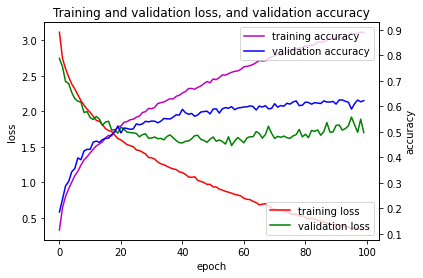

In [101]:
viz_model('results/FinecompletedatasetmodelH.pt')


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

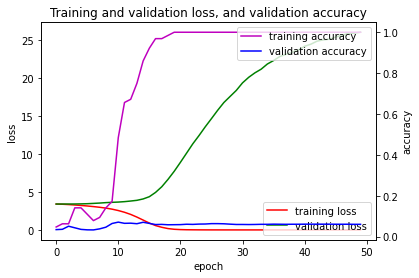

In [ ]:
#single batch
viz_model('results/singlebatch50epochs.pt')

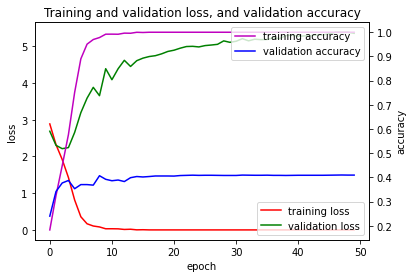

In [ ]:
#full training 
viz_model('results/completedataset50epochs.pt')

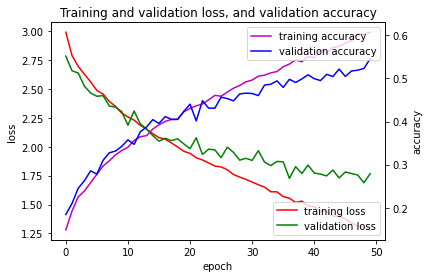

In [ ]:
#fine-tuned
viz_model('results/Finecompletedataset50epochs2dropout.pt')

Explain what can be seen in the graphs.

--> Double click here to respond


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [86]:
categories_names=(pd.read_csv(mapping_img30,header=None,sep="\t")).drop(columns=[2])
categories_names=categories_names[1]
categories_names = categories_names.tolist()

In [77]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)  

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_all_pred(model,loader,categories_names):
    all_preds=torch.tensor([])
    all_labels=torch.tensor([])
    i=0
    with torch.no_grad():
        for batch in tqdm(loader):
            images,label=batch
            preds=model(images.to(device=device))
            
            all_preds=torch.cat((all_preds.to(device=device),preds.to(device=device)),dim=0)
            all_labels=torch.cat((all_labels.to(device=device),label.to(device=device)),dim=0)
            
        fig, ax = plt.subplots(figsize=(10,10))
        cm=confusion_matrix(all_labels.tolist(),all_preds.argmax(dim=1).tolist())
        conf_matrix=pd.DataFrame(data=cm,columns=categories_names
                                          ,index=categories_names)
        sns.heatmap(conf_matrix, annot=True, fmt="d",)
        
        plt.show()

        # show per-class recall and precision
        print(f"Accuracy: {accuracy(cm) :.1%}")
        r = recalls(cm)
        p = precisions(cm)
        for i in range(len(categories_names)):
            print(f"Class {categories_names[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:26<00:00,  6.41it/s]


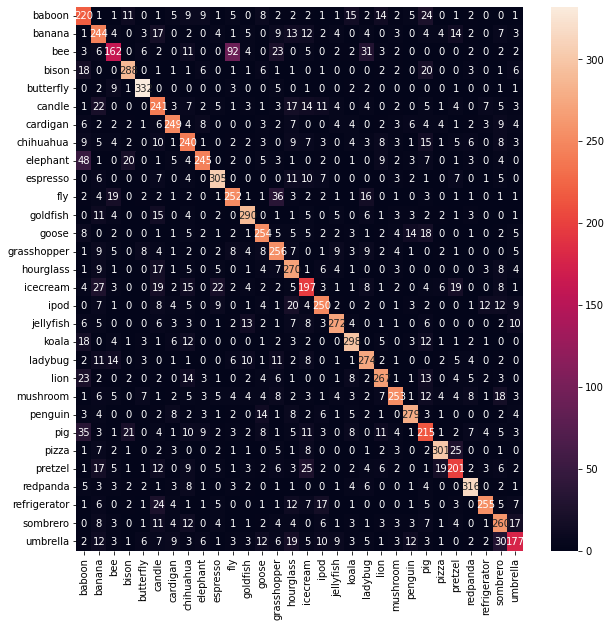

Accuracy: 71.0%
Class baboon : Precision 52.4%  Recall 63.8%
Class banana : Precision 55.5%  Recall 67.4%
Class bee : Precision 63.0%  Recall 45.0%
Class bison : Precision 81.1%  Recall 80.0%
Class butterfly : Precision 88.3%  Recall 92.2%
Class candle : Precision 56.7%  Recall 65.8%
Class cardigan : Precision 78.3%  Recall 73.7%
Class chihuahua : Precision 60.0%  Recall 67.6%
Class elephant : Precision 81.9%  Recall 66.8%
Class espresso : Precision 79.4%  Recall 82.7%
Class fly : Precision 63.5%  Recall 70.8%
Class goldfish : Precision 81.0%  Recall 80.6%
Class goose : Precision 72.6%  Recall 73.4%
Class grasshopper : Precision 62.6%  Recall 72.7%
Class hourglass : Precision 61.4%  Recall 76.9%
Class icecream : Precision 57.3%  Recall 55.0%
Class ipod : Precision 73.7%  Recall 69.8%
Class jellyfish : Precision 82.7%  Recall 76.4%
Class koala : Precision 79.0%  Recall 79.3%
Class ladybug : Precision 71.2%  Recall 75.7%
Class lion : Precision 76.3%  Recall 72.8%
Class mushroom : Precisi

In [110]:
get_all_pred(model_122e,train_loader,categories_names)

What conclusions can be drawn from the confusion matrices?

---> Double click to respond here



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [19]:
test_dir = ROOT + "test_set/test_set"
img_paths= []
img_name= []

for entry in os.scandir(test_dir):
    if (entry.is_file()):
        img_paths.append(entry.path)
        img_name.append(entry.name)
            
data = {'path': img_paths,'class': 0}

test_df = pd.DataFrame(data, columns=['path','class'])


print("length of test images = ", len(test_df), "image")
print(test_df.head())

transfrm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
test_dataset = TinyImageNet30(
    df=test_df,
    transform=transfrm,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

length of test images =  1500 image
                                                path  class
0  /content/drive/MyDrive/comp5623m-2022/test_set...      0
1  /content/drive/MyDrive/comp5623m-2022/test_set...      0
2  /content/drive/MyDrive/comp5623m-2022/test_set...      0
3  /content/drive/MyDrive/comp5623m-2022/test_set...      0
4  /content/drive/MyDrive/comp5623m-2022/test_set...      0


In [20]:

dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images.size())

timshow(utils.make_grid(images))
print(*labels.numpy())  

torch.Size([64, 3, 64, 64])


NameError: ignored

In [105]:
predicted_class = []
for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward, backward, and update parameters
        outputs = model_122h(inputs)
        
        # the predicted lables / classes
        _, predicted = torch.max(outputs.data, 1)
        #add the predicted lables to the list
        predicted_class.extend(predicted.tolist()) 


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [ ]:
# TO COMPLETE

In [106]:
data = {'ID': img_name,'Category': predicted_class}

In [107]:
test_df =pd.DataFrame(data,columns=['ID','Category'])

print("test length", len(data_df))
test_df.head()

test length 13500


,ID,Category
0,7f19ba4a_9471.JPEG,26
1,ff1e4f2b_5114.JPEG,7
2,b31f291a_7c51.JPEG,26
3,bb79ae30_cb47.JPEG,20
4,76978129_c38e.JPEG,22


In [108]:
test_df.to_csv("ml20baya.csv", index= False, header=True)

In [109]:
!cp ml20baya.csv "/content/drive/MyDrive/comp5623m-2022"



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

In [ ]:
model.features

In [ ]:
model.features[0]

In [ ]:
model.features[0].weight.shape


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [ ]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight.detach()
    # TO COMPLETE
    return filters

In [ ]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [ ]:
filters[0].shape

In [ ]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



In [ ]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [ ]:
# TO COMPLETE
from PIL import Image

im = Image.open('/content/drive/MyDrive/comp5623m-2022/man_bike.JPEG')
im = im.convert('RGB')

Run the code cell below to apply the image transformation expected by the model.

In [ ]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [ ]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
    
    
    max_pool_layer = [2,5,12]
    
    
    feature_maps = []
    model_length = len(model.features)
    for i in range(model_length):
        image = model.features[i].forward(image)
        # extract the feature map in the max pool layers
        if i in max_pool_layer:
            feature_map = image
            feature_maps.append(feature_map)


    return feature_maps

In [ ]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

In [ ]:
feature_maps[0][0].shape

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [ ]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

In [ ]:
to_show = 16

plt_dim = int(math.sqrt(to_show))

for j in range(len(feature_maps)):
    print("max pool layer", j)
    for i, filt in enumerate(feature_maps[j][0].detach().numpy()[:to_show]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show()




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


--> Double click here to respond

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

--> Double click here to respond

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

--> Double click here to respond


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [ ]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model = alexnet(pretrained=True)

In [ ]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [ ]:
output

In [ ]:
pred_cls

In [ ]:
mapping = pd.read_table('/content/drive/MyDrive/comp5623m-2022/alexaNet_mapping/imagenet1000_clsidx_to_labels.txt', header = None)

In [ ]:
mapping.iloc[int(pred_cls)]

### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [ ]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    output[:,class_id].backward()
    
    
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations and squeeze out the extra dimension
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    
    # TO COMPLETE
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap) 
    
    return heatmap

In [ ]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

In [ ]:
plt.matshow(heatmap)

In [ ]:
heatmap.shape

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [ ]:
def display_heatmap(heatmap,image):
#1

  heatmap = cv2.resize(heatmap.numpy(), (image.shape[0], image.shape[1]))
  
#2 

  numer = heatmap - np.min(heatmap)
  denom = (heatmap.max() - heatmap.min()) + 1e-8
  heatmap_norm = numer / denom
  heatmap_norm = (heatmap_norm * 255).astype("uint8")
 
#3
  heatmap_norm = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
#4
  heatmap_norm=heatmap_norm * 0.4
#5
  #heatmap_normalized=heatmap_normalized.reshape((256,256,1))*np.ones([256,256,3])
  w_image= cv2.addWeighted(heatmap_norm, 0.7, image, 0.3, 0)
#6
  numer = w_image - np.min(w_image)
  denom = (w_image.max() - w_image.min()) + 1e-8
  final_image = numer / denom
  final_image = (final_image * 255).astype("uint8")

  return final_image

In [ ]:
im_bike = cv2.imread('/content/drive/MyDrive/comp5623m-2022/man_bike.JPEG')
im_bike=cv2.resize(im_bike,(256,256))
im_bike = np.asarray(im_bike, np.float64)

In [ ]:
display=display_heatmap(heatmap,im_bike)
plt.matshow(display[:, :, ::-1])

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [ ]:
output_978 = model(im.unsqueeze(0))

In [ ]:
heatmap = generate_heatmap(output_978, torch.tensor(978), model, im.unsqueeze(0))
display=display_heatmap(heatmap,im_bike)

In [ ]:
plt.matshow(display[:, :, ::-1])

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

In [ ]:
# TO COMPLETE
from PIL import Image

im_simpson = Image.open('/content/drive/MyDrive/comp5623m-2022/bart-simpson.jpg')
im_simpson = im_simpson.convert('RGB')
im_simpson

In [ ]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im_simpson = data_transform(im_simpson)

In [ ]:
model = alexnet(pretrained=True)

In [ ]:
# pass our test image through our new model with the hook
output = model(im_simpson.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)
pred_cls

In [ ]:
mapping.iloc[int(pred_cls)]

In [ ]:
heatmap_simpson = generate_heatmap(output, pred_cls, model, im_simpson.unsqueeze(0))

In [ ]:
im_simpson = cv2.imread('/content/drive/MyDrive/comp5623m-2022/bart-simpson.jpg')
im_simpson=cv2.resize(im_simpson,(256,256))
im_simpson = np.asarray(im_simpson, np.float64)

In [ ]:
#heatmap
display=display_heatmap(heatmap,im_simpson)
plt.matshow(display[:, :, ::-1])

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

--> Double click to respond here

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
